## **Projeto Final de Introdução à Ciência de Dados**

### **Estudantes**
Danielle Ester Barbosa da Silva e Luísa Oliveira Gonçalves

### **Base SRAG escolhida**
Base de dados da Síndrome Respiratória Aguda Grave (SRAG), no período de 2019 a 2025.

### **Subproblema**
Diferenças regionais.

### **Objetivo**
Desenvolver uma análise exploratória e um modelo de aprendizado de máquina para compreensão dos aspectos associados às diferenças regionais de pacientes diagnosticados com COVID-19 no Brasil.

### **Coleta dos dados**
Banco de dados da Síndrome Respiratória Aguda Grave (SRAG) - 2019 a 2025
Endereço: https://opendatasus.saude.gov.br/dataset/srag-2021-a-2024
Arquivos coletados estão disponíveis no diretório ./data



## Bibliotecas do projeto

#### pandas (pd)
*   Utilizada para carregar os datasets, realizar limpeza, filtrar registros, agrupar dados e preparar as variáveis para análise e modelagem.

#### numpy (np)
*   Utilizada em operações matemáticas e normalização/transformação de valores numéricos.

#### pathlib.Path
*   Utilizada para localizar e carregar os arquivos de dados do projeto.

#### matplotlib.pyplot (plt)
*   Utilizada para visualização dos gráficos.

#### seaborn (sns)
*   Utilizada para visualização de gráficos agrupados.

#### matplotlib.ticker.FuncFormatter
*   Utilizada para formatação personalizada dos rótulos nos eixos dos gráficos.

In [3]:

from matplotlib.ticker import FuncFormatter
from pathlib import Path
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

### **Seleção das Variáveis**

As variáveis foram selecionadas mediante análise do dicionário de dados do SIVEP-Gripe, adotando critérios que se alinham ao subproblema de investigação — especificamente, a identificação de diferenças regionais nos desfechos clínicos da COVID-19.

In [4]:
VARIAVEIS = {
    'SG_UF': 'VARCHAR2(2)',                 # UF de residência - página 6
    'CLASSI_FIN': 'VARCHAR2(1)',            # Classificação final do caso - página 24
    'EVOLUCAO': 'VARCHAR2(1)',              # Evolução do caso - página 24
    'CS_ZONA': 'VARCHAR2(1)',               # Zona geográfica - página 7
    'HOSPITAL': 'VARCHAR2(1)',              # Houve internação - página 15
    'UTI': 'VARCHAR2(1)',                   # Internado em UTI - página 16
    'VACINA_COV': 'VARCHAR2(1)',            # Recebeu vacina COVID-19 - página 10
    'PCR_SARS2': 'VARCHAR2(1)',             # Marcador SARS-CoV-2 (RT-PCR) - seção agentes etiológicos
    
    # VARIÁVEIS ADICIONADAS APÓS TESTE INICIAL DA MODELAGEM:
    'NU_IDADE_N': 'VARCHAR2(3)',            # Idade - página 4
    'TP_IDADE': 'VARCHAR2(1)',              # Tipo/Idade (Dia/Mês/Ano) - página 4
    'DT_NASC': 'DATE',                      # Data de nascimento - página 4
    
    # 2. Comorbidades
    'DIABETES': 'VARCHAR2(1)',              # Diabetes mellitus - página 9
    'CARDIOPATI': 'VARCHAR2(1)',            # Doença Cardiovascular Crônica - página 9
    'OBESIDADE': 'VARCHAR2(1)',             # Obesidade - página 10
    'OBES_IMC': 'VARCHAR2(3)',              # Valor do IMC - página 10
    'RENAL': 'VARCHAR2(1)',                 # Doença Renal Crônica - página 10
    'PNEUMOPATI': 'VARCHAR2(1)',            # Outra Pneumopatia Crônica - página 9
    'ASMA': 'VARCHAR2(1)',                  # Asma - página 9
    'NEUROLOGIC': 'VARCHAR2(1)',            # Doença Neurológica Crônica - página 9
    'HEPATICA': 'VARCHAR2(1)',              # Doença Hepática Crônica - página 9
    'HEMATOLOGI': 'VARCHAR2(1)',            # Doença Hematológica Crônica - página 9
    'IMUNODEPRE': 'VARCHAR2(1)',            # Imunodeficiência - página 10
    
    # 3. Datas de sintomas e internação
    'DT_SIN_PRI': 'DATE',                   # Data de 1ºs sintomas - página 2
    'DT_INTERNA': 'DATE',                   # Data da internação por SRAG - página 16
    'DT_ENTUTI': 'DATE',                    # Data da entrada na UTI - página 16
    
    # 4. Tipo de vacina e número de doses
    'DOSE_1_COV': 'VARCHAR2(10)',           # Data 1ª dose - página 10
    'DOSE_2_COV': 'VARCHAR2(10)',           # Data 2ª dose - página 11
    'DOSE_REF': 'VARCHAR2(10)',             # Data dose reforço - página 11
    'DOSE_2REF': 'VARCHAR2(10)',            # Data 2ª dose reforço - página 11
    'DOSE_ADIC': 'VARCHAR2(10)',            # Data dose adicional - página 11
    'DOS_RE_BI': 'VARCHAR2(10)',            # Data dose reforço bivalente - página 11
}


DOMINIOS_VALIDOS = {
    'SG_UF': {
        'descricao': 'Unidade Federativa de residência (padrão IBGE)',
        'valores_validos': [
            'AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'DF', 'ES', 'GO', 'MA', 'MT', 'MS', 
            'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 
            'SP', 'SE', 'TO'
        ]
    },

    'CLASSI_FIN': {
        'descricao': 'Classificação final do caso',
        'valores': {
            '1': 'SRAG por influenza',
            '2': 'SRAG por outro vírus respiratório',
            '3': 'SRAG por outro agente etiológico',
            '4': 'SRAG não especificado',
            '5': 'SRAG por covid-19'
        },
        'valores_validos': ['1', '2', '3', '4', '5']
    },

    'EVOLUCAO': {
        'descricao': 'Evolução do caso',
        'valores': {
            '1': 'Cura',
            '2': 'Óbito',
            '3': 'Óbito por outras causas',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '3', '9']
    },

    'CS_ZONA': {
        'descricao': 'Zona geográfica do endereço de residência',
        'valores': {
            '1': 'Urbana',
            '2': 'Rural',
            '3': 'Periurbana',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '3', '9']
    },

    'HOSPITAL': {
        'descricao': 'Houve internação?',
        'valores': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '9']
    },

    'UTI': {
        'descricao': 'Internado em UTI?',
        'valores': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '9']
    },

    'VACINA_COV': {
        'descricao': 'Recebeu vacina COVID-19?',
        'valores': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '9']
    },

    'PCR_SARS2': {
        'descricao': 'Detecção de SARS-CoV-2 por RT-PCR',
        'valores': {
            '1': 'Detectado',
            '2': 'Não detectado'
        },
        'valores_validos': ['1', '2']
    },

    'TP_IDADE': {
        'descricao': 'Tipo/Idade (unidade de medida da idade)',
        'valores': {
            '1': 'Dia',
            '2': 'Mês',
            '3': 'Ano'
        },
        'valores_validos': ['1', '2', '3']
    },

    'DIABETES': {
        'descricao': 'Paciente possui Diabetes mellitus?',
        'valores': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '9']
    },

    'CARDIOPATI': {
        'descricao': 'Paciente possui Doença Cardiovascular Crônica?',
        'valores': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '9']
    },

    'OBESIDADE': {
        'descricao': 'Paciente possui obesidade?',
        'valores': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '9']
    },

    'RENAL': {
        'descricao': 'Paciente possui Doença Renal Crônica?',
        'valores': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '9']
    },

    'PNEUMOPATI': {
        'descricao': 'Paciente possui outra pneumopatia crônica?',
        'valores': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '9']
    },

    'ASMA': {
        'descricao': 'Paciente possui Asma?',
        'valores': {
            '1': 'Sim',
            '2': 'Não',
            '9': 'Ignorado'
        },
        'valores_validos': ['1', '2', '9']
    }
}


### Carregamento dos dados

O processo de carregamento dos dados foi implementado por meio de uma função que acessa os arquivos em formato CSV, correspondentes aos bancos de dados anuais do Sistema de Informação da Vigilância Epidemiológica da Gripe (SIVEP-Gripe). A função realiza:

* a leitura dos arquivos com codificação padronizada (latin1) e tratamento de linhas inconsistentes; 
* a verificação da presença das variáveis predefinidas no dicionário de dados, permitindo identificar possíveis inconsistências nas bases ao longo dos anos; 
* e a consolidação dos dados em um único DataFrame

In [5]:
def carregar_dados():
    arquivos = sorted(Path('data').glob('INFLUD*.csv'))
    dfs = []
    
    for arquivo in arquivos:
        # Configurações específicas para leitura de dados SIVEP-Gripe (formato brasileiro)
        df = pd.read_csv(
            arquivo,
            sep=';',                 # Separador brasileiro
            dtype=str,               # Preserva zeros à esquerda
            encoding='latin1',       # Caracteres acentuados
            low_memory=False,        # Otimização para grandes arquivos
            on_bad_lines='skip'      # Ignora linhas malformadas
        )

        # Identificar variáveis existentes e faltantes
        variaveis_existentes = [v for v in VARIAVEIS if v in df.columns]
        variaveis_faltantes = [v for v in VARIAVEIS if v not in df.columns]
        
        # Manter apenas variáveis existentes
        df = df[variaveis_existentes].copy()

        dfs.append(df)

        # Exibir informações detalhadas
        print(f"Carregado: {arquivo.name}")
        print(f"- Registros: {len(df):,}")
        print(f"- Variáveis encontradas: {len(variaveis_existentes)}/{len(VARIAVEIS)}")
        
        # Mostrar variáveis faltantes (apenas se houver)
        if variaveis_faltantes:
            print(f"Variáveis faltantes ({len(variaveis_faltantes)}):")
            for i, var in enumerate(variaveis_faltantes, 1):
                print(f"      {i:2d}. {var}")
        else:
            print(f"Todas as {len(VARIAVEIS)} variáveis foram encontradas")
        
        print()  # Linha em branco para separação
    
    # Consolidar todos os dados
    df_final = pd.concat(dfs, ignore_index=True)
    
    # Análise consolidada de variáveis
    print("=" * 60)
    print("RESUMO DOS DADOS:")
    print("=" * 60)
    print(f"Total de arquivos processados: {len(arquivos)}")
    print(f"Total final de registros: {len(df_final):,}")
    
    # Verificar quais variáveis estão presentes no DataFrame final
    variaveis_finais = [v for v in VARIAVEIS if v in df_final.columns]
    faltantes_finais = [v for v in VARIAVEIS if v not in df_final.columns]
    
    print(f"\nVariáveis presentes no conjunto final: {len(variaveis_finais)}/{len(VARIAVEIS)}")
    
    if faltantes_finais:
        print("\nVariáveis ausentes em TODOS os arquivos:")
        for var in faltantes_finais:
            print(f"  • {var}")
    
    return df_final


if __name__ == "__main__":
    df = carregar_dados()

Carregado: INFLUD19-26-06-2025.csv
- Registros: 48,961
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD20-26-06-2025.csv
- Registros: 1,206,920
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD21-26-06-2025.csv
- Registros: 1,745,672
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD22-26-06-2025.csv
- Registros: 560,577
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD23-26-06-2025.csv
- Registros: 279,453
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD24-26-06-2025.csv
- Registros: 267,984
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

Carregado: INFLUD25-01-12-2025.csv
- Registros: 309,502
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

RESUMO DOS DADOS:
Total de arquivos processados: 7
Total final de registros: 4,419,069

Variáveis pre

### Análise da qualidade dos dados

Realiza um diagnóstico da qualidade dos dados epidemiológicos, focando em valores nulos, validade com o domínio das variáveis e alertas para análises regionais.

In [6]:
def diagnostico_preliminar(df):
    print("\nQUALIDADE DOS DADOS")
    print("=" * 70)

    df = df.copy()

    null_tokens = ["None", "NONE", "nan", "NaN", "", "NULL", "null", "NA", "na"]
    df = df.replace(null_tokens, pd.NA)

    n = len(df)
    nulos = df.isna().sum()
    pct_nulos = (nulos / n * 100).round(1)

    campos_regiao = [
        'SG_UF', 'CS_ZONA', 'CLASSI_FIN', 'EVOLUCAO', 
        'HOSPITAL', 'UTI', 'NU_IDADE_N', 'VACINA_COV', 'PCR_SARS2'
    ]

    print("\n1. VARIÁVEIS ESSENCIAIS E % DE NULOS")
    print("-" * 70)

    for col in campos_regiao:
        if col in df.columns:
            p = pct_nulos[col]
            impacto = (
                "ALTO impacto" if p > 30 else
                "impacto moderado" if p > 10 else
                "impacto baixo"
            )
            print(f"- {col:<12} {p:>5}% nulos → {impacto}")

    print("\n2. VALORES FORA DO DOMÍNIO")
    print("-" * 70)

    for col, info in DOMINIOS_VALIDOS.items():
        if col not in df.columns:
            continue
        
        validos = info.get("valores_validos")
        if not validos:
            continue

        valores = df[col].dropna().astype(str)
        invalidos = valores[~valores.isin(validos)]

        if len(invalidos) > 0:
            pct_invalid = round(len(invalidos) / n * 100, 1)
            exemplos = invalidos.value_counts().head(3).index.tolist()
            print(f"- {col:<12} {pct_invalid}% inválidos → exemplos: {exemplos}")

    print("\n3. ALERTAS PARA DIFERENÇAS REGIONAIS")
    print("-" * 70)

    alertas = []

    if pct_nulos.get("SG_UF", 0) > 5:
        alertas.append("SG_UF com proporção elevada de nulos.")

    if pct_nulos.get("CLASSI_FIN", 0) > 20:
        alertas.append("CLASSI_FIN apresenta incompletude relevante.")

    if pct_nulos.get("EVOLUCAO", 0) > 20:
        alertas.append("EVOLUCAO apresenta incompletude relevante.")

    if pct_nulos.get("HOSPITAL", 0) > 20:
        alertas.append("HOSPITAL possui nulos em excesso.")

    if pct_nulos.get("PCR_SARS2", 0) > 40:
        alertas.append("PCR_SARS2 extremamente incompleto — evitar uso isolado.")

    vac_cols = [c for c in df.columns if "VACINA" in c or "DOSE" in c]
    if vac_cols and pct_nulos[vac_cols].mean() > 80:
        alertas.append("Variáveis de vacinação estão amplamente incompletas.")

    if alertas:
        for msg in alertas:
            print(f"- {msg}")
    else:
        print("Nenhum alerta crítico identificado.")

    print("=" * 70)
    return df


if __name__ == "__main__":
    df_analisado = diagnostico_preliminar(df)


QUALIDADE DOS DADOS

1. VARIÁVEIS ESSENCIAIS E % DE NULOS
----------------------------------------------------------------------
- SG_UF          0.0% nulos → impacto baixo
- CS_ZONA       10.1% nulos → impacto moderado
- CLASSI_FIN     3.8% nulos → impacto baixo
- EVOLUCAO       7.4% nulos → impacto baixo
- HOSPITAL       2.6% nulos → impacto baixo
- UTI           13.1% nulos → impacto moderado
- NU_IDADE_N     0.0% nulos → impacto baixo
- VACINA_COV    34.7% nulos → ALTO impacto
- PCR_SARS2     68.8% nulos → ALTO impacto

2. VALORES FORA DO DOMÍNIO
----------------------------------------------------------------------
- CLASSI_FIN   26.6% inválidos → exemplos: ['5.0', '4.0', '2.0']
- EVOLUCAO     25.6% inválidos → exemplos: ['1.0', '2.0', '9.0']
- PCR_SARS2    11.8% inválidos → exemplos: ['1.0']

3. ALERTAS PARA DIFERENÇAS REGIONAIS
----------------------------------------------------------------------
- PCR_SARS2 extremamente incompleto — evitar uso isolado.


In [7]:
def limpar_dados(df):
    df = df.copy()
    total_removed = 0

    # --- Normalização de valores categóricos
    def limpar_valor(v):
        if pd.isna(v):
            return pd.NA
        return str(v).strip().replace(".0", "")

    cat_cols = ['CLASSI_FIN', 'EVOLUCAO', 'PCR_SARS2',
                'CS_ZONA', 'VACINA_COV', 'UTI', 'HOSPITAL']

    for col in cat_cols:
        if col in df.columns:
            df.loc[:, col] = df[col].apply(limpar_valor)

    print("- Normalizados valores categóricos.")

    # --- Tratamento de idade
    if 'NU_IDADE_N' in df.columns:
        df.loc[:, 'NU_IDADE_N'] = pd.to_numeric(df['NU_IDADE_N'], errors='coerce')

        before = len(df)
        df = df[df['NU_IDADE_N'].between(0, 110)]
        removed = before - len(df)
        total_removed += removed

        if removed > 0:
            print(f"- Removidas {removed} linhas por idades impossíveis.")

        # Conversão de dias/meses para anos
        if 'TP_IDADE' in df.columns:
            tp = df['TP_IDADE'].astype(str)
            df.loc[tp == '1', 'NU_IDADE_N'] /= 365
            df.loc[tp == '2', 'NU_IDADE_N'] /= 12
            print("- Idades em dias/meses convertidas para anos.")

    # --- Preenchimento de nulos
    for col in ['CS_ZONA', 'UTI', 'VACINA_COV', 'HOSPITAL']:
        if col in df.columns:
            df.loc[:, col] = df[col].fillna("9")

    print("- Nulos padronizados em CS_ZONA, UTI, VACINA_COV e HOSPITAL.")

    # --- Conversão de datas
    def parse_date_safe(series):
        s1 = pd.to_datetime(series, errors='coerce', format="%d/%m/%Y")
        s2 = pd.to_datetime(series, errors='coerce', format="%Y-%m-%d")
        return s1.fillna(s2)

    date_cols = [
        'DT_SIN_PRI', 'DT_INTERNA', 'DT_ENTUTI', 'DT_NASC',
        'DOSE_1_COV', 'DOSE_2_COV', 'DOSE_REF',
        'DOSE_2REF', 'DOSE_ADIC', 'DOS_RE_BI'
    ]

    for col in date_cols:
        if col in df.columns:
            df.loc[:, col] = parse_date_safe(df[col])

    print("- Datas convertidas.")

    # --- Tratamento de datas impossíveis de nascimento
    if 'DT_NASC' in df.columns:
        before = len(df)
        df.loc[:, 'DT_NASC'] = df['DT_NASC'].mask(
            (df['DT_NASC'] < pd.Timestamp("1900-01-01")) |
            (df['DT_NASC'] > pd.Timestamp("2025-01-01"))
        )
        removed = before - len(df)
        total_removed += removed

        print("- Datas de nascimento irreais tratadas.")

    # --- Remoção de valores fora do domínio
    for col, info in DOMINIOS_VALIDOS.items():
        if col not in df.columns or col == "PCR_SARS2":
            continue

        validos = info.get("valores_validos")
        if not validos:
            continue

        before = len(df)
        df = df[df[col].isin(validos) | df[col].isna()]
        removed = before - len(df)
        total_removed += removed

        if removed > 0:
            print(f"- Removidas {removed:,} linhas inválidas de {col}.")

    # --- Recodificação final de campos críticos
    for col in ['CLASSI_FIN', 'EVOLUCAO']:
        if col in df.columns:
            df.loc[:, col] = df[col].fillna("9")

    print("- Nulos recodificados em CLASSI_FIN e EVOLUCAO.")

    # --- Finalização
    print(f"\nTotal de linhas removidas: {total_removed:,}")

    return df


if __name__ == "__main__":
    df_tratado = limpar_dados(df)


- Normalizados valores categóricos.
- Removidas 191 linhas por idades impossíveis.
- Idades em dias/meses convertidas para anos.
- Nulos padronizados em CS_ZONA, UTI, VACINA_COV e HOSPITAL.
- Datas convertidas.
- Datas de nascimento irreais tratadas.
- Nulos recodificados em CLASSI_FIN e EVOLUCAO.

Total de linhas removidas: 191


In [8]:
def gerar_estatisticas_regionais(df):
    df = df.copy()

    # --------------------------------------------------
    # 1. Mapeamento Estado → Região
    # --------------------------------------------------
    regioes = {
        'Norte': ['AC','AP','AM','PA','RO','RR','TO'],
        'Nordeste': ['AL','BA','CE','MA','PB','PE','PI','RN','SE'],
        'Centro-Oeste': ['DF','GO','MS','MT'],
        'Sudeste': ['ES','MG','RJ','SP'],
        'Sul': ['PR','RS','SC']
    }

    df["REGIAO"] = np.nan
    for regiao, ufs in regioes.items():
        df.loc[df["SG_UF"].isin(ufs), "REGIAO"] = regiao

    df = df[df["REGIAO"].notna()].copy()

    # --------------------------------------------------
    # 2. Seleção dos pacientes de interesse
    # --------------------------------------------------
    comorb_cols = [
        "DIABETES", "CARDIOPATI", "OBESIDADE", "RENAL",
        "PNEUMOPATI", "ASMA", "NEUROLOGIC", "HEPATICA",
        "HEMATOLOGI", "IMUNODEPRE"
    ]

    df["HAS_COMORB"] = df[comorb_cols].apply(lambda row: (row == "1").any(), axis=1)

    filtro = (
        (df["CLASSI_FIN"] == "5") &
        (df["HOSPITAL"] == "1") &
        (df["UTI"] == "1") &
        (df["HAS_COMORB"] == True)
    )

    df_critico = df[filtro].copy()

    print(f"\nTotal de pacientes no grupo crítico: {len(df_critico):,}")
    print("- Critérios: Covid (5) + Internado + UTI + ≥1 comorbidade\n")

    # --------------------------------------------------
    # 3. Estatísticas Etárias por Região (com dispersão)
    # --------------------------------------------------
    print("\n1. PERFIL ETÁRIO POR REGIÃO (GRUPO CRÍTICO)")
    print("-" * 120)

    for regiao, grupo in df_critico.groupby("REGIAO"):
        idade = grupo["NU_IDADE_N"].dropna()
        if idade.empty:
            continue

        media = idade.mean()
        mediana = idade.median()
        p25 = idade.quantile(0.25)
        p75 = idade.quantile(0.75)
        amplitude = idade.max() - idade.min()
        desvio = idade.std()
        variancia = idade.var()
        cv = (desvio / media * 100) if media > 0 else np.nan

        print(f"\n→ {regiao}")
        print(f"  Média:                 {media:.1f}")
        print(f"  Mediana:               {mediana:.1f}")
        print(f"  P25–P75 (IQR):         ({p25:.1f} – {p75:.1f})")
        print(f"  Amplitude:             {amplitude:.1f}")
        print(f"  Desvio padrão:         {desvio:.1f}")
        print(f"  Variância:             {variancia:.1f}")
        print(f"  Coeficiente de variação:{cv:.1f}%")

    # --------------------------------------------------
    # 4. Desfecho
    # --------------------------------------------------
    print("\n2. DESFECHO (CURA × ÓBITO) POR REGIÃO — GRUPO CRÍTICO")
    print("-" * 120)

    for regiao, grupo in df_critico.groupby("REGIAO"):
        evol = grupo["EVOLUCAO"].value_counts(normalize=True)
        pct_cura = evol.get("1", 0) * 100
        pct_obito = evol.get("2", 0) * 100

        print(f"\n→ {regiao}")
        print(f"  % Cura:        {pct_cura:.1f}%")
        print(f"  % Óbito:       {pct_obito:.1f}%")

    # --------------------------------------------------
    # 5. Comorbidades
    # --------------------------------------------------
    print("\n3. PRINCIPAIS COMORBIDADES POR REGIÃO (FREQUÊNCIA)")
    print("-" * 120)

    for regiao, grupo in df_critico.groupby("REGIAO"):
        print(f"\n→ {regiao}")
        freq = grupo[comorb_cols].apply(lambda col: (col == "1").mean() * 100)
        print(freq.sort_values(ascending=False).round(1).to_string())

    return df_critico

if __name__ == "__main__":
    df_critico = gerar_estatisticas_regionais(df_tratado)

/tmp/ipykernel_4532/2370866871.py:17: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Norte' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df["SG_UF"].isin(ufs), "REGIAO"] = regiao



Total de pacientes no grupo crítico: 438,531
- Critérios: Covid (5) + Internado + UTI + ≥1 comorbidade


1. PERFIL ETÁRIO POR REGIÃO (GRUPO CRÍTICO)
------------------------------------------------------------------------------------------------------------------------

→ Centro-Oeste
  Média:                 63.5
  Mediana:               65.0
  P25–P75 (IQR):         (53.0 – 76.0)
  Amplitude:             110.0
  Desvio padrão:         17.1
  Variância:             290.8
  Coeficiente de variação:26.8%

→ Nordeste
  Média:                 64.3
  Mediana:               66.0
  P25–P75 (IQR):         (54.0 – 77.0)
  Amplitude:             110.0
  Desvio padrão:         17.4
  Variância:             303.0
  Coeficiente de variação:27.1%

→ Norte
  Média:                 62.5
  Mediana:               65.0
  P25–P75 (IQR):         (53.0 – 74.0)
  Amplitude:             110.0
  Desvio padrão:         16.9
  Variância:             286.3
  Coeficiente de variação:27.1%

→ Sudeste
  Média:    

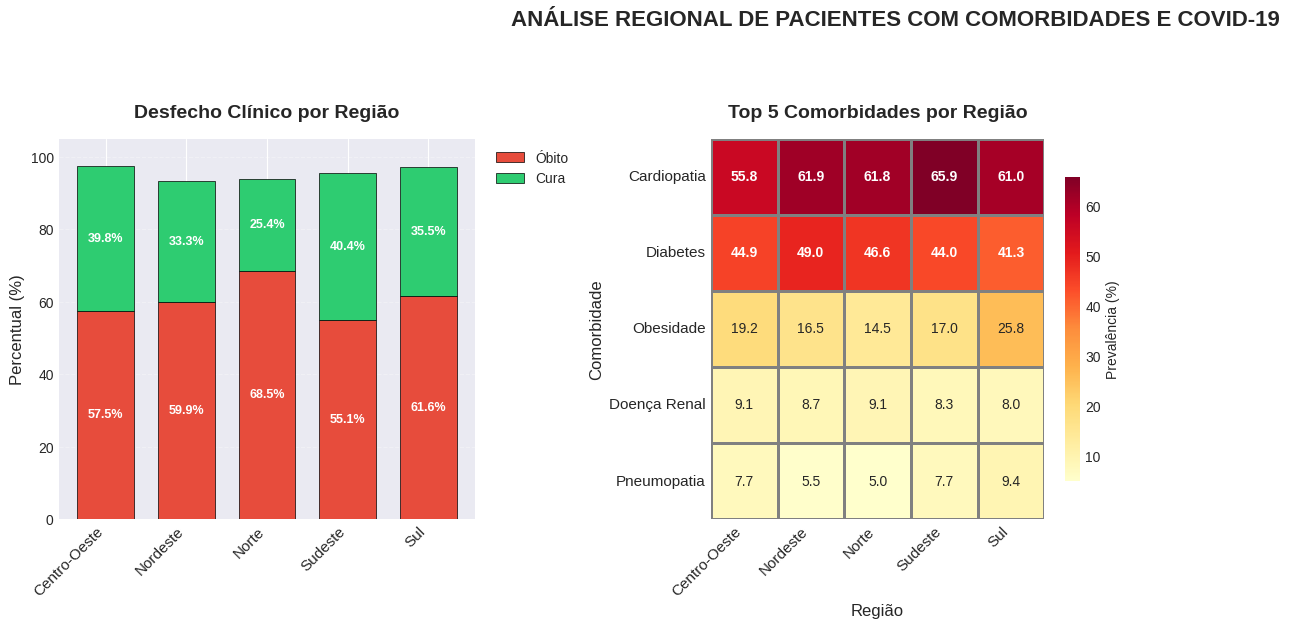

In [9]:
def gerar_graficos_painel(df_critico):
    colunas_necessarias = ['REGIAO', 'NU_IDADE_N', 'EVOLUCAO', 'HAS_COMORB']
    comorb_cols = [
        "DIABETES", "CARDIOPATI", "OBESIDADE", "RENAL",
        "PNEUMOPATI", "ASMA", "NEUROLOGIC", "HEPATICA",
        "HEMATOLOGI", "IMUNODEPRE"
    ]
    
    for col in colunas_necessarias:
        if col not in df_critico.columns:
            raise ValueError(f"Coluna '{col}' não encontrada no DataFrame")
    
    # Configuração do estilo
    plt.style.use('seaborn-v0_8-darkgrid')
    sns.set_palette("husl")
    
    # ============================================
    # PROCESSAR DADOS
    # ============================================
    
    # Lista de regiões (ordenadas)
    regioes = sorted(df_critico['REGIAO'].unique())
    
    # Arrays para armazenar resultados
    obito_pct = []
    cura_pct = []
    outros_pct = []
    
    idade_media = []
    idade_p25 = []
    idade_p75 = []
    idade_mediana = []
    
    # Dicionário para comorbidades
    comorbidades = {}
    for comorb in comorb_cols:
        comorbidades[comorb] = []
    
    # Processar cada região
    for regiao in regioes:
        grupo = df_critico[df_critico['REGIAO'] == regiao]
        
        # 1. Estatísticas de desfecho
        evol = grupo['EVOLUCAO'].value_counts(normalize=True) * 100
        pct_cura = evol.get("1", 0)
        pct_obito = evol.get("2", 0)
        pct_outros = 100 - (pct_cura + pct_obito)
        
        cura_pct.append(pct_cura)
        obito_pct.append(pct_obito)
        outros_pct.append(pct_outros)
        
        # 2. Estatísticas de idade
        idade = grupo['NU_IDADE_N'].dropna()
        if not idade.empty:
            idade_media.append(idade.mean())
            idade_mediana.append(idade.median())
            idade_p25.append(idade.quantile(0.25))
            idade_p75.append(idade.quantile(0.75))
        else:
            idade_media.append(0)
            idade_mediana.append(0)
            idade_p25.append(0)
            idade_p75.append(0)
        
        # 3. Prevalência de comorbidades
        for comorb in comorb_cols:
            if comorb in grupo.columns:
                prevalencia = (grupo[comorb] == "1").mean() * 100
                comorbidades[comorb].append(prevalencia)
            else:
                comorbidades[comorb].append(0)
    
    # Selecionar as 5 principais comorbidades (baseado na média)
    comorb_medias = {comorb: np.mean(vals) for comorb, vals in comorbidades.items()}
    top_5_comorb = sorted(comorb_medias.items(), key=lambda x: x[1], reverse=True)[:5]
    top_5_nomes = [nome for nome, _ in top_5_comorb]
    
    # Mapear nomes mais amigáveis para as comorbidades
    nome_amigavel = {
        'CARDIOPATI': 'Cardiopatia',
        'DIABETES': 'Diabetes',
        'OBESIDADE': 'Obesidade',
        'RENAL': 'Doença Renal',
        'PNEUMOPATI': 'Pneumopatia',
        'ASMA': 'Asma',
        'NEUROLOGIC': 'Neurológica',
        'HEPATICA': 'Hepática',
        'HEMATOLOGI': 'Hematológica',
        'IMUNODEPRE': 'Imunodepressão'
    }
    
    # Preparar dados das top 5 comorbidades
    comorbidades_top5 = {}
    for comorb in top_5_nomes:
        nome = nome_amigavel.get(comorb, comorb)
        comorbidades_top5[nome] = comorbidades[comorb]
    
    # ============================================
    # CRIAR OS GRÁFICOS
    # ============================================
    
    fig = plt.figure(figsize=(18, 10))
    
    # Título geral
    n_total = f"{len(df_critico):,}".replace(",", ".")
    fig.suptitle('ANÁLISE REGIONAL DE PACIENTES COM COMORBIDADES E COVID-19\n',
                fontsize=16, fontweight='bold', y=1.02)
    
    # ============================================
    # GRÁFICO 1: DESFECHO POR REGIÃO (Barras empilhadas)
    # ============================================
    ax1 = plt.subplot(2, 3, 1)
    
    bar_width = 0.7
    x_pos = np.arange(len(regioes))
    
    bars_obito = ax1.bar(x_pos, obito_pct, bar_width, label='Óbito', 
                        color='#e74c3c', edgecolor='black', linewidth=0.5)
    bars_cura = ax1.bar(x_pos, cura_pct, bar_width, bottom=obito_pct, 
                       label='Cura', color='#2ecc71', edgecolor='black', linewidth=0.5)
    
    for i, (obito, cura) in enumerate(zip(obito_pct, cura_pct)):
        if obito > 0:
            ax1.text(i, obito/2, f'{obito:.1f}%', ha='center', va='center', 
                    fontsize=9, fontweight='bold', color='white')
        if cura > 0:
            ax1.text(i, obito + cura/2, f'{cura:.1f}%', ha='center', va='center', 
                    fontsize=9, fontweight='bold', color='white')
    
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(regioes, rotation=45, ha='right', fontsize=11)
    ax1.set_ylabel('Percentual (%)', fontsize=12)
    ax1.set_title('Desfecho Clínico por Região', fontsize=14, fontweight='bold', pad=15)
    ax1.set_ylim(0, 105)
    
    # Adicionar grid horizontal
    ax1.yaxis.grid(True, linestyle='--', alpha=0.3)
    ax1.set_axisbelow(True)
    
    # Legenda
    ax1.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10)
    
    # ============================================
    # GRÁFICO 2: MAPA DE CALOR DAS COMORBIDADES
    # ============================================
    ax2 = plt.subplot(2, 3, 2)
    
    # Preparar dados para o heatmap
    df_comorb = pd.DataFrame(comorbidades_top5, index=regioes)
    
    # Criar heatmap
    sns.heatmap(df_comorb.T, annot=True, fmt='.1f', cmap='YlOrRd', 
                linewidths=1, linecolor='gray', cbar_kws={'label': 'Prevalência (%)', 'shrink': 0.8},
                ax=ax2, annot_kws={"size": 10})
    
    ax2.set_title(f'Top {len(top_5_nomes)} Comorbidades por Região', 
                 fontsize=14, fontweight='bold', pad=15)
    ax2.set_xlabel('Região', fontsize=12)
    ax2.set_ylabel('Comorbidade', fontsize=12)
    
    # Rotacionar labels do eixo x
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=11)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=11)
    
    # Destacar células com valores altos
    for text in ax2.texts:
        t = float(text.get_text())
        if t > 50:
            text.set_fontweight('bold')
            text.set_color('white')
        elif t > 30:
            text.set_fontweight('bold')
    
    plt.tight_layout()
    
    # Salvar figura
    plt.savefig('analise_regional_covid_grave.png', dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()
    
    return fig

if __name__ == "__main__":
    fig = gerar_graficos_painel(df_critico)

In [10]:
# Importação das ferramentas necessárias
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    roc_auc_score, 
    accuracy_score,
    precision_recall_fscore_support
)
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# ==============================================================================
# 1. CRIAÇÃO DE NOVAS INFORMAÇÕES ÚTEIS
# ==============================================================================

def criar_novas_informacoes(dados_limpos):
    """
    Cria novas informações a partir dos dados existentes para melhorar a previsão.
    
    - Transforma idade em faixas etárias
    - Conta quantas doenças a pessoa tem
    - Calcula tempo entre eventos importantes
    - Cria indicadores de gravidade
    """
    
    # Cópia para não alterar os dados originais
    dados_com_novas_info = dados_limpos.copy()
    
    print("=" * 80)
    print("INICIANDO A CRIAÇÃO DE NOVAS INFORMAÇÕES")
    print("=" * 80)
    
    # -------------------------------------------------------------------------
    # 1.1 DEFININDO O QUE QUEREMOS PREVER: ÓBITO (1) vs CURA (0)
    # -------------------------------------------------------------------------
    print("\n1. Criando o que vamos prever (RESULTADO_FINAL_OBITO)...")
    
    # Mantemos apenas casos onde sabemos o que aconteceu: 1=Cura, 2=Óbito
    dados_com_novas_info = dados_com_novas_info[dados_com_novas_info['EVOLUCAO'].isin(['1', '2'])].copy()
    
    # Criamos uma nova coluna: 1 se foi óbito, 0 se foi cura
    dados_com_novas_info['RESULTADO_FINAL_OBITO'] = (dados_com_novas_info['EVOLUCAO'] == '2').astype(int)
    
    print(f"   - Pessoas que faleceram: {dados_com_novas_info['RESULTADO_FINAL_OBITO'].sum():,}")
    print(f"   - Pessoas que se curaram: {(dados_com_novas_info['RESULTADO_FINAL_OBITO'] == 0).sum():,}")
    print(f"   - Porcentagem que faleceram: {dados_com_novas_info['RESULTADO_FINAL_OBITO'].mean()*100:.2f}%")
    
    # -------------------------------------------------------------------------
    # 1.2 INFORMAÇÕES SOBRE A PESSOA
    # -------------------------------------------------------------------------
    print("\n2. Analisando informações pessoais...")
    
    # Convertemos idade para número (alguns podem estar como texto)
    dados_com_novas_info['IDADE_NUMERO'] = pd.to_numeric(dados_com_novas_info['NU_IDADE_N'], errors='coerce')
    
    # Criamos grupos de idade (faixas etárias) como: crianças, adultos, idosos
    dados_com_novas_info['GRUPO_IDADE'] = pd.cut(
        dados_com_novas_info['IDADE_NUMERO'], 
        bins=[0, 18, 40, 60, 80, 120],
        labels=['Criança/Adolescente (0-18)', 'Adulto Jovem (19-40)', 
                'Adulto (41-60)', 'Idoso (61-80)', 'Idoso Avançado (80+)']
    )
    
    # Definimos em que região do Brasil a pessoa mora
    if 'REGIAO' not in dados_com_novas_info.columns:
        mapa_regioes = {
            'Norte': ['AC','AP','AM','PA','RO','RR','TO'],
            'Nordeste': ['AL','BA','CE','MA','PB','PE','PI','RN','SE'],
            'Centro-Oeste': ['DF','GO','MS','MT'],
            'Sudeste': ['ES','MG','RJ','SP'],
            'Sul': ['PR','RS','SC']
        }
        
        dados_com_novas_info['REGIAO'] = np.nan
        for nome_regiao, lista_estados in mapa_regioes.items():
            dados_com_novas_info.loc[dados_com_novas_info['SG_UF'].isin(lista_estados), 'REGIAO'] = nome_regiao
    
    # Verificamos se mora na cidade (urbano) ou no campo (rural)
    dados_com_novas_info['MORA_CIDADE'] = (dados_com_novas_info['CS_ZONA'] == '1').astype(int)
    
    print(f"   - Idade média: {dados_com_novas_info['IDADE_NUMERO'].mean():.1f} anos")
    print(f"   - Grupos de idade criados: {dados_com_novas_info['GRUPO_IDADE'].nunique()}")
    print(f"   - Regiões identificadas: {dados_com_novas_info['REGIAO'].nunique()}")
    
    # -------------------------------------------------------------------------
    # 1.3 INFORMAÇÕES SOBRE DOENÇAS EXISTENTES
    # -------------------------------------------------------------------------
    print("\n3. Contabilizando outras doenças que a pessoa já tinha...")
    
    # Lista de doenças que podemos verificar
    lista_doencas_existentes = [
        'DIABETES', 'CARDIOPATI', 'OBESIDADE', 'RENAL',
        'PNEUMOPATI', 'ASMA', 'NEUROLOGIC', 'HEPATICA',
        'HEMATOLOGI', 'IMUNODEPRE'
    ]
    
    # Para cada doença, marcamos 1 se a pessoa tinha, 0 se não tinha
    for doenca in lista_doencas_existentes:
        if doenca in dados_com_novas_info.columns:
            dados_com_novas_info[f'{doenca}_BINARIO'] = (dados_com_novas_info[doenca] == '1').astype(int)
    
    # Contamos quantas doenças a pessoa tinha no total
    colunas_doencas_binarias = [f'{doenca}_BINARIO' for doenca in lista_doencas_existentes 
                              if f'{doenca}_BINARIO' in dados_com_novas_info.columns]
    dados_com_novas_info['TOTAL_DOENCAS_EXISTENTES'] = dados_com_novas_info[colunas_doencas_binarias].sum(axis=1)
    
    # Criamos grupos de risco baseado no número de doenças
    dados_com_novas_info['NIVEL_RISCO'] = pd.cut(
        dados_com_novas_info['TOTAL_DOENCAS_EXISTENTES'],
        bins=[-1, 0, 1, 2, 10],
        labels=['Sem outras doenças', '1 doença prévia', '2 doenças prévias', '3+ doenças prévias']
    )
    
    print(f"   - Média de doenças prévias: {dados_com_novas_info['TOTAL_DOENCAS_EXISTENTES'].mean():.2f}")
    print(f"   - Distribuição por nível de risco:")
    print(dados_com_novas_info['NIVEL_RISCO'].value_counts().to_string())
    
    # -------------------------------------------------------------------------
    # 1.4 INFORMAÇÕES SOBRE TEMPO ENTRE EVENTOS
    # -------------------------------------------------------------------------
    print("\n4. Calculando tempos importantes...")
    
    # Convertemos datas de texto para formato de data
    for coluna_data in ['DT_SIN_PRI', 'DT_INTERNA', 'DT_ENTUTI']:
        if coluna_data in dados_com_novas_info.columns:
            dados_com_novas_info[coluna_data] = pd.to_datetime(dados_com_novas_info[coluna_data], errors='coerce')
    
    # Calculamos quanto tempo passou entre sintomas e internação
    if 'DT_SIN_PRI' in dados_com_novas_info.columns and 'DT_INTERNA' in dados_com_novas_info.columns:
        dados_com_novas_info['DIAS_SINTOMAS_ATE_INTERNACAO'] = (dados_com_novas_info['DT_INTERNA'] - dados_com_novas_info['DT_SIN_PRI']).dt.days
        
        # Corrigimos valores extremos (menos de 0 dias ou mais de 1 ano)
        dados_com_novas_info['DIAS_SINTOMAS_ATE_INTERNACAO'] = dados_com_novas_info['DIAS_SINTOMAS_ATE_INTERNACAO'].clip(lower=0, upper=365)
        
        print(f"   - Tempo médio sintomas→internação: {dados_com_novas_info['DIAS_SINTOMAS_ATE_INTERNACAO'].mean():.1f} dias")
    
    # Calculamos quanto tempo passou entre internação e entrada na UTI
    if 'DT_INTERNA' in dados_com_novas_info.columns and 'DT_ENTUTI' in dados_com_novas_info.columns:
        dados_com_novas_info['DIAS_INTERNACAO_ATE_UTI'] = (dados_com_novas_info['DT_ENTUTI'] - dados_com_novas_info['DT_INTERNA']).dt.days
        dados_com_novas_info['DIAS_INTERNACAO_ATE_UTI'] = dados_com_novas_info['DIAS_INTERNACAO_ATE_UTI'].clip(lower=0, upper=365)
        
        print(f"   - Tempo médio internação→UTI: {dados_com_novas_info['DIAS_INTERNACAO_ATE_UTI'].mean():.1f} dias")
    
    # -------------------------------------------------------------------------
    # 1.5 INFORMAÇÕES SOBRE VACINAÇÃO
    # -------------------------------------------------------------------------
    print("\n5. Verificando situação vacinal...")
    
    # Marca se a pessoa foi vacinada (1) ou não (0)
    dados_com_novas_info['RECEBEU_VACINA'] = (dados_com_novas_info['VACINA_COV'] == '1').astype(int)
    
    # Contamos quantas doses a pessoa recebeu
    colunas_doses = ['DOSE_1_COV', 'DOSE_2_COV', 'DOSE_REF', 'DOSE_2REF', 'DOSE_ADIC', 'DOS_RE_BI']
    dados_com_novas_info['TOTAL_DOSES'] = 0
    
    for coluna_dose in colunas_doses:
        if coluna_dose in dados_com_novas_info.columns:
            # Convertemos para data e contamos se tem data válida
            dados_com_novas_info[coluna_dose] = pd.to_datetime(dados_com_novas_info[coluna_dose], errors='coerce')
            dados_com_novas_info['TOTAL_DOSES'] += dados_com_novas_info[coluna_dose].notna().astype(int)
    
    print(f"   - Porcentagem vacinada: {dados_com_novas_info['RECEBEU_VACINA'].mean()*100:.1f}%")
    print(f"   - Distribuição por número de doses:")
    print(dados_com_novas_info['TOTAL_DOSES'].value_counts().sort_index().to_string())
    
    # -------------------------------------------------------------------------
    # 1.6 CRIANDO UM INDICADOR DE GRAVIDADE
    # -------------------------------------------------------------------------
    print("\n6. Criando um indicador de quão grave foi o caso...")
    
    # Marca se a pessoa foi para UTI
    dados_com_novas_info['FOI_PARA_UTI'] = (dados_com_novas_info['UTI'] == '1').astype(int)
    
    # Marca se a pessoa foi hospitalizada
    dados_com_novas_info['FOI_HOSPITALIZADA'] = (dados_com_novas_info['HOSPITAL'] == '1').astype(int)
    
    # Criamos um "score" de gravidade (quanto maior, mais grave)
    # Pontuação: UTI=3 pontos, Hospitalizado=2 pontos, Idade>=60=1 ponto, 3+ doenças prévias=2 pontos
    dados_com_novas_info['SCORE_GRAVIDADE'] = (
        dados_com_novas_info['FOI_PARA_UTI'] * 3 +
        dados_com_novas_info['FOI_HOSPITALIZADA'] * 2 +
        (dados_com_novas_info['IDADE_NUMERO'] >= 60).astype(int) +
        (dados_com_novas_info['TOTAL_DOENCAS_EXISTENTES'] >= 3).astype(int) * 2
    )
    
    print(f"   - Porcentagem que foi para UTI: {dados_com_novas_info['FOI_PARA_UTI'].mean()*100:.1f}%")
    print(f"   - Score de gravidade médio: {dados_com_novas_info['SCORE_GRAVIDADE'].mean():.2f}")
    
    print("\n" + "=" * 80)
    print("CRIAÇÃO DE NOVAS INFORMAÇÕES CONCLUÍDA")
    print("=" * 80)
    
    return dados_com_novas_info


# ==============================================================================
# 2. PREPARANDO OS DADOS PARA O COMPUTADOR APRENDER
# ==============================================================================

def preparar_dados_para_aprendizado(dados_com_todas_info):
    """
    Prepara os dados para o computador conseguir entender e aprender:
    - Escolhe as informações mais importantes
    - Remove dados faltantes
    - Transforma categorias em números
    - Separa o que queremos prever das informações que usamos para prever
    """
    
    print("\n" + "=" * 80)
    print("PREPARANDO DADOS PARA O COMPUTADOR APRENDER")
    print("=" * 80)
    
    dados = dados_com_todas_info.copy()
    
    # -------------------------------------------------------------------------
    # 2.1 ESCOLHENDO AS INFORMAÇÕES MAIS IMPORTANTES
    # -------------------------------------------------------------------------
    print("\n1. Selecionando as informações mais relevantes...")
    
    # Informações numéricas (números)
    informacoes_numericas = [
        'IDADE_NUMERO',
        'TOTAL_DOENCAS_EXISTENTES',
        'TOTAL_DOSES',
        'SCORE_GRAVIDADE',
        'DIAS_SINTOMAS_ATE_INTERNACAO',
        'DIAS_INTERNACAO_ATE_UTI'
    ]
    
    # Informações de sim/não (binárias)
    informacoes_sim_nao = [
        'RECEBEU_VACINA',
        'FOI_PARA_UTI',
        'FOI_HOSPITALIZADA',
        'MORA_CIDADE'
    ]
    
    # Doenças específicas (cada uma como sim/não)
    informacoes_doencas_especificas = [
        'DIABETES_BINARIO', 'CARDIOPATI_BINARIO', 'OBESIDADE_BINARIO',
        'RENAL_BINARIO', 'PNEUMOPATI_BINARIO'
    ]
    
    # Informações de categorias (como região, faixa etária)
    informacoes_categorias = ['REGIAO', 'GRUPO_IDADE', 'NIVEL_RISCO']
    
    # Juntamos todas as informações selecionadas
    todas_informacoes_selecionadas = (
        informacoes_numericas + 
        informacoes_sim_nao + 
        informacoes_doencas_especificas + 
        informacoes_categorias
    )
    
    # Mantemos apenas as informações que realmente existem nos dados
    informacoes_disponiveis = [info for info in todas_informacoes_selecionadas if info in dados.columns]
    
    print(f"   - Informações selecionadas: {len(informacoes_disponiveis)}")
    
    # -------------------------------------------------------------------------
    # 2.2 LIDANDO COM DADOS FALTANTES
    # -------------------------------------------------------------------------
    print("\n2. Tratando dados que estão faltando...")
    
    # Criamos um novo conjunto só com as informações selecionadas e o resultado final
    dados_para_modelo = dados[informacoes_disponiveis + ['RESULTADO_FINAL_OBITO']].copy()
    
    print(f"   - Registros antes do tratamento: {len(dados_para_modelo):,}")
    
    # Para informações numéricas faltantes, usamos o valor do meio (mediana)
    for coluna_num in informacoes_numericas:
        if coluna_num in dados_para_modelo.columns:
            valor_do_meio = dados_para_modelo[coluna_num].median()
            dados_para_modelo[coluna_num].fillna(valor_do_meio, inplace=True)
    
    # Removemos linhas onde faltam informações de categorias
    dados_para_modelo = dados_para_modelo.dropna(subset=informacoes_categorias)
    
    print(f"   - Registros depois do tratamento: {len(dados_para_modelo):,}")
    print(f"   - Registros removidos: {len(dados) - len(dados_para_modelo):,}")
    
    # -------------------------------------------------------------------------
    # 2.3 TRANSFORMANDO CATEGORIAS EM NÚMEROS
    # -------------------------------------------------------------------------
    print("\n3. Transformando categorias em números que o computador entende...")
    
    # "One-hot encoding": cria uma coluna separada para cada categoria
    # Exemplo: Região "Norte" vira coluna REGIAO_Norte com valor 1 (sim) ou 0 (não)
    dados_transformados = pd.get_dummies(
        dados_para_modelo, 
        columns=informacoes_categorias,
        drop_first=True  # Evita criar colunas desnecessárias
    )
    
    print(f"   - Dimensão após transformação: {dados_transformados.shape}")
    
    # -------------------------------------------------------------------------
    # 2.4 SEPARANDO O QUE QUEREMOS PREVER DAS INFORMAÇÕES QUE USAMOS
    # -------------------------------------------------------------------------
    print("\n4. Separando o alvo (o que queremos prever) dos dados de entrada...")
    
    # O que queremos prever: se a pessoa faleceu (1) ou se curou (0)
    alvo_previsao = dados_transformados['RESULTADO_FINAL_OBITO']
    
    # As informações que usamos para fazer a previsão
    dados_para_prever = dados_transformados.drop('RESULTADO_FINAL_OBITO', axis=1)
    
    print(f"   - Formato dos dados de entrada: {dados_para_prever.shape}")
    print(f"   - Formato do alvo: {alvo_previsao.shape}")
    print(f"   - Porcentagem de óbitos no total: {alvo_previsao.mean()*100:.2f}%")
    
    print("\n" + "=" * 80)
    print("PREPARAÇÃO DOS DADOS CONCLUÍDA")
    print("=" * 80)
    
    return dados_para_prever, alvo_previsao, dados_transformados


# ==============================================================================
# 3. DIVIDINDO EM TREINO/TESTE E AJUSTANDO A ESCALA
# ==============================================================================

def dividir_e_ajustar_escala(dados_entrada, alvo, tamanho_teste=0.3, semente_aleatoria=42):
    """
    Divide os dados em dois grupos: para treinar o computador e para testar o que ele aprendeu.
    Também ajusta a escala das informações para que todas tenham o mesmo "peso".
    
    Por que 70% treino e 30% teste?
    - 70% para treino: o computador precisa de bastante exemplos para aprender bem
    - 30% para teste: precisamos verificar se ele realmente aprendeu, não apenas decorou
    - É uma proporção comum e equilibrada
    """
    
    print("\n" + "=" * 80)
    print("DIVIDINDO DADOS E AJUSTANDO ESCALAS")
    print("=" * 80)
    
    # -------------------------------------------------------------------------
    # 3.1 DIVIDINDO OS DADOS
    # -------------------------------------------------------------------------
    porcentagem_treino = int((1-tamanho_teste)*100)
    porcentagem_teste = int(tamanho_teste*100)
    print(f"\n1. Dividindo os dados (treino: {porcentagem_treino}%, teste: {porcentagem_teste}%)...")
    
    # Dividimos mantendo a mesma proporção de óbitos em ambos os grupos
    dados_entrada_treino, dados_entrada_teste, alvo_treino, alvo_teste = train_test_split(
        dados_entrada, alvo,
        test_size=tamanho_teste,
        random_state=semente_aleatoria,
        stratify=alvo  # Mantém a mesma proporção de óbitos em treino e teste
    )
    
    print(f"   - Dados de treino: {len(dados_entrada_treino):,} registros ({len(dados_entrada_treino)/len(dados_entrada)*100:.1f}%)")
    print(f"   - Dados de teste: {len(dados_entrada_teste):,} registros ({len(dados_entrada_teste)/len(dados_entrada)*100:.1f}%)")
    print(f"\n   - Porcentagem óbitos (treino): {alvo_treino.mean()*100:.2f}%")
    print(f"   - Porcentagem óbitos (teste): {alvo_teste.mean()*100:.2f}%")
    
    # -------------------------------------------------------------------------
    # 3.2 AJUSTANDO A ESCALA DAS INFORMAÇÕES
    # -------------------------------------------------------------------------
    print("\n2. Ajustando a escala das informações...")
    print("   Por que ajustar a escala?")
    print("   - Imagine comparar idade (0-100) com número de doses (0-5)")
    print("   - Sem ajuste, a idade pareceria muito mais importante só porque tem números maiores")
    print("   - Ajustando a escala, damos peso igual a todas as informações")
    
    # Criamos um "ajustador de escala"
    ajustador_escala = StandardScaler()
    
    # Ajustamos a escala usando APENAS os dados de treino
    # (Isso é importante para não "roubar" informação dos dados de teste)
    dados_entrada_treino_escala_ajustada = ajustador_escala.fit_transform(dados_entrada_treino)
    dados_entrada_teste_escala_ajustada = ajustador_escala.transform(dados_entrada_teste)
    
    # Convertemos de volta para tabela (mantendo os nomes das colunas)
    dados_entrada_treino_escala_ajustada = pd.DataFrame(
        dados_entrada_treino_escala_ajustada, 
        columns=dados_entrada_treino.columns,
        index=dados_entrada_treino.index
    )
    
    dados_entrada_teste_escala_ajustada = pd.DataFrame(
        dados_entrada_teste_escala_ajustada, 
        columns=dados_entrada_teste.columns,
        index=dados_entrada_teste.index
    )
    
    print(f"   - Informações com escala ajustada: {dados_entrada_treino_escala_ajustada.shape[1]}")
    
    print("\n" + "=" * 80)
    print("DADOS PRONTOS PARA O COMPUTADOR APRENDER")
    print("=" * 80)
    
    return dados_entrada_treino_escala_ajustada, dados_entrada_teste_escala_ajustada, alvo_treino, alvo_teste, ajustador_escala


# ==============================================================================
# 4. ENSINANDO O COMPUTADOR A PREVER
# ==============================================================================

def ensinar_computador_a_prever(dados_treino, alvo_treino, dados_teste, alvo_teste):
    """
    Ensina o computador a prever óbitos usando Regressão Logística.
    É como ensinar uma criança: mostramos exemplos (treino) e depois testamos se aprendeu (teste).
    """
    
    print("\n" + "=" * 80)
    print("ENSINANDO O COMPUTADOR A PREVER (REGRESSÃO LOGÍSTICA)")
    print("=" * 80)
    
    # -------------------------------------------------------------------------
    # 4.1 ENSINANDO O COMPUTADOR
    # -------------------------------------------------------------------------
    print("\n1. Ensinando o computador com os dados de treino...")
    
    # Criamos um "cérebro" vazio para o computador (o modelo)
    cerebro_computador = LogisticRegression(
        max_iter=1000,           # Damos tempo suficiente para aprender
        random_state=42,         # Usamos mesma "semente" para resultados consistentes
        class_weight='balanced', # Damos mais atenção aos casos raros (óbitos)
        solver='lbfgs'           # Usamos método eficiente de aprendizado
    )
    
    # Ensinamos o computador com os dados de treino
    cerebro_computador.fit(dados_treino, alvo_treino)
    
    print("   ✓ Computador treinado com sucesso")
    
    # -------------------------------------------------------------------------
    # 4.2 TESTANDO O QUE O COMPUTADOR APRENDEU
    # -------------------------------------------------------------------------
    print("\n2. Testando o que o computador aprendeu...")
    
    # Pedimos para o computador prever os resultados
    previsoes_treino = cerebro_computador.predict(dados_treino)
    previsoes_teste = cerebro_computador.predict(dados_teste)
    
    # Também pedimos a "confiança" de cada previsão (probabilidade)
    probabilidades_treino = cerebro_computador.predict_proba(dados_treino)[:, 1]
    probabilidades_teste = cerebro_computador.predict_proba(dados_teste)[:, 1]
    
    # -------------------------------------------------------------------------
    # 4.3 AVALIANDO O DESEMPENHO DO COMPUTADOR
    # -------------------------------------------------------------------------
    print("\n3. Avaliando o desempenho do computador...")
    
    print("\n" + "-" * 80)
    print("DESEMPENHO NOS DADOS DE TREINO (O QUE ELE VIU DURANTE O TREINO)")
    print("-" * 80)
    
    # Acurácia: porcentagem de acertos totais
    acuracia_treino = accuracy_score(alvo_treino, previsoes_treino)
    print(f"\nAcurácia (acertos totais): {acuracia_treino:.4f} ({acuracia_treino*100:.2f}%)")
    
    # Precisão, Recall e F1: diferentes formas de medir acertos
    precisao, recall, f1, _ = precision_recall_fscore_support(
        alvo_treino, previsoes_treino, average='binary'
    )
    
    print(f"Precisão (quando diz que é óbito, acerta): {precisao:.4f}")
    print(f"Recall (consegue identificar os óbitos): {recall:.4f}")
    print(f"F1-Score (média balanceada): {f1:.4f}")
    
    # AUC-ROC: mede a capacidade geral de distinguir óbitos de curas
    auc_treino = roc_auc_score(alvo_treino, probabilidades_treino)
    print(f"AUC-ROC (capacidade de distinguir): {auc_treino:.4f}")
    
    # Matriz de Confusão: mostra onde o computador acerta e erra
    print("\nMatriz de Confusão (o que preveu vs o que realmente aconteceu):")
    matriz_confusao_treino = confusion_matrix(alvo_treino, previsoes_treino)
    print(matriz_confusao_treino)
    print("Legenda:")
    print("  [Cura prevista corretamente]  [Cura prevista como óbito (erro)]")
    print("  [Óbito previsto como cura (erro)]  [Óbito previsto corretamente]")
    
    print("\n" + "-" * 80)
    print("DESEMPENHO NOS DADOS DE TESTE (O QUE ELE NUNCA VIU ANTES)")
    print("-" * 80)
    
    # As mesmas métricas, mas agora nos dados de teste
    acuracia_teste = accuracy_score(alvo_teste, previsoes_teste)
    print(f"\nAcurácia (acertos totais): {acuracia_teste:.4f} ({acuracia_teste*100:.2f}%)")
    
    precisao, recall, f1, _ = precision_recall_fscore_support(
        alvo_teste, previsoes_teste, average='binary'
    )
    
    print(f"Precisão (quando diz que é óbito, acerta): {precisao:.4f}")
    print(f"Recall (consegue identificar os óbitos): {recall:.4f}")
    print(f"F1-Score (média balanceada): {f1:.4f}")
    
    auc_teste = roc_auc_score(alvo_teste, probabilidades_teste)
    print(f"AUC-ROC (capacidade de distinguir): {auc_teste:.4f}")
    
    print("\nMatriz de Confusão (o que preveu vs o que realmente aconteceu):")
    matriz_confusao_teste = confusion_matrix(alvo_teste, previsoes_teste)
    print(matriz_confusao_teste)
    
    # Relatório completo
    print("\n" + "-" * 80)
    print("RELATÓRIO COMPLETO DE DESEMPENHO (TESTE)")
    print("-" * 80)
    print(classification_report(alvo_teste, previsoes_teste, target_names=['Cura', 'Óbito']))
    
    # -------------------------------------------------------------------------
    # 4.4 ENTENDENDO O QUE O COMPUTADOR APRENDEU
    # -------------------------------------------------------------------------
    print("\n" + "-" * 80)
    print("AS 10 INFORMAÇÕES MAIS IMPORTANTES QUE O COMPUTADOR APRENDEU")
    print("-" * 80)
    
    # O computador aprendeu "pesos" para cada informação
    # Peso positivo: aumenta a chance de óbito
    # Peso negativo: diminui a chance de óbito
    pesos_aprendidos = pd.DataFrame({
        'Informação': dados_treino.columns,
        'Peso_Aprendido': cerebro_computador.coef_[0]
    })
    
    # Calculamos a importância (valor absoluto do peso)
    pesos_aprendidos['Importancia_Absoluta'] = np.abs(pesos_aprendidos['Peso_Aprendido'])
    pesos_aprendidos = pesos_aprendidos.sort_values('Importancia_Absoluta', ascending=False)
    
    print("\n(Pesos positivos aumentam risco de óbito, negativos diminuem)")
    print(pesos_aprendidos.head(10).to_string(index=False))
    
    print("\n" + "=" * 80)
    print("PROCESSO DE APRENDIZADO CONCLUÍDO")
    print("=" * 80)
    
    # Guardamos tudo o que aprendemos
    resultado_aprendizado = {
        'cerebro_computador': cerebro_computador,
        'desempenho_treino': {
            'acuracia': acuracia_treino,
            'auc_roc': auc_treino
        },
        'desempenho_teste': {
            'acuracia': acuracia_teste,
            'precisao': precisao,
            'recall': recall,
            'f1_score': f1,
            'auc_roc': auc_teste
        },
        'matriz_confusao': matriz_confusao_teste,
        'pesos_aprendidos': pesos_aprendidos
    }
    
    return resultado_aprendizado

# ==============================================================================
# 6. PROCESSO COMPLETO DO INÍCIO AO FIM
# ==============================================================================

def executar_processo_completo_aprendizado(dados_limpos):
    """
    Executa todo o processo de aprendizado do computador:
    1. Cria novas informações úteis
    2. Prepara os dados
    3. Divide em treino e teste
    4. Ensina o computador
    5. Avalia o que ele aprendeu
    """
    
    print("\n" + "=" * 80)
    print("INICIANDO PROCESSO COMPLETO DE APRENDIZADO DE MÁQUINA")
    print("=" * 80)
    
    # 1. Criamos novas informações a partir dos dados
    dados_com_todas_info = criar_novas_informacoes(dados_limpos)
    
    # 2. Preparamos os dados para o computador entender
    dados_entrada, alvo_previsao, dados_transformados = preparar_dados_para_aprendizado(dados_com_todas_info)
    
    # 3. Dividimos em dados para treinar e dados para testar
    dados_treino, dados_teste, alvo_treino, alvo_teste, ajustador_escala = dividir_e_ajustar_escala(dados_entrada, alvo_previsao)
    
    # 4. Ensinamos o computador e avaliamos o que ele aprendeu
    resultado_aprendizado = ensinar_computador_a_prever(dados_treino, alvo_treino, dados_teste, alvo_teste)
    
    print("\n" + "=" * 80)
    print("PROCESSO COMPLETO CONCLUÍDO COM SUCESSO!")
    print("=" * 80)
    
    # Retornamos tudo o que foi feito
    return {
        'dados_com_todas_info': dados_com_todas_info,
        'dados_treino': dados_treino,
        'dados_teste': dados_teste,
        'alvo_treino': alvo_treino,
        'alvo_teste': alvo_teste,
        'ajustador_escala': ajustador_escala,
        'resultado_aprendizado': resultado_aprendizado
    }

# ==============================================================================
# EXECUTANDO O PROCESSO
# ==============================================================================

if __name__ == "__main__":
    # Executamos todo o processo
    resultado_final = executar_processo_completo_aprendizado(df_tratado)

    # Mostramos os resultados principais
    cerebro_treinado = resultado_final['resultado_aprendizado']['cerebro_computador']
    metricas_finais = resultado_final['resultado_aprendizado']['desempenho_teste']


INICIANDO PROCESSO COMPLETO DE APRENDIZADO DE MÁQUINA
INICIANDO A CRIAÇÃO DE NOVAS INFORMAÇÕES

1. Criando o que vamos prever (RESULTADO_FINAL_OBITO)...
   - Pessoas que faleceram: 922,588
   - Pessoas que se curaram: 2,990,897
   - Porcentagem que faleceram: 23.57%

2. Analisando informações pessoais...


/tmp/ipykernel_4532/3187809765.py:82: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Norte' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  dados_com_novas_info.loc[dados_com_novas_info['SG_UF'].isin(lista_estados), 'REGIAO'] = nome_regiao


   - Idade média: 48.5 anos
   - Grupos de idade criados: 5
   - Regiões identificadas: 5

3. Contabilizando outras doenças que a pessoa já tinha...
   - Média de doenças prévias: 0.70
   - Distribuição por nível de risco:
NIVEL_RISCO
Sem outras doenças    2132345
1 doença prévia       1056495
2 doenças prévias      535058
3+ doenças prévias     189587

4. Calculando tempos importantes...
   - Tempo médio sintomas→internação: 5.9 dias
   - Tempo médio internação→UTI: 1.2 dias

5. Verificando situação vacinal...
   - Porcentagem vacinada: 28.1%
   - Distribuição por número de doses:
TOTAL_DOSES
0    2902986
1     191570
2     451086
3     217855
4     102405
5      46744
6        839

6. Criando um indicador de quão grave foi o caso...
   - Porcentagem que foi para UTI: 28.9%
   - Score de gravidade médio: 3.31

CRIAÇÃO DE NOVAS INFORMAÇÕES CONCLUÍDA

PREPARANDO DADOS PARA O COMPUTADOR APRENDER

1. Selecionando as informações mais relevantes...
   - Informações selecionadas: 18

2. Trat

In [ ]:
# ============================================================================
# 1. ANÁLISE ESPACIAL - VISUALIZAÇÕES GEOGRÁFICAS
# ============================================================================

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# ============================================================================
# 2. MODELAGEM PREDITIVA - COMPLETANDO O PIPELINE
# ============================================================================

from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

def preparar_dados_modelagem(df_tratado):
    """
    Prepara dados para modelagem preditiva com foco em diferenças regionais
    """
    df_modelo = df_tratado.copy()
    
    # 1. Criar variável alvo baseada em diferenças regionais
    # Opção A: Prever se paciente é do Norte/Nordeste (regiões com pior desfecho)
    df_modelo['REGIAO_CRITICA'] = df_modelo['REGIAO'].apply(
        lambda x: 1 if x in ['Norte', 'Nordeste'] else 0
    )
    
    # Opção B: Prever óbito baseado em características + região
    df_modelo['ALVO_OBITO'] = (df_modelo['EVOLUCAO'] == '2').astype(int)
    
    # 2. Selecionar features relevantes para análise regional
    features = [
        # Demográficas
        'NU_IDADE_N', 'CS_ZONA',
        
        # Clínicas
        'DIABETES', 'CARDIOPATI', 'OBESIDADE', 'RENAL', 'PNEUMOPATI',
        'ASMA', 'NEUROLOGIC', 'HEPATICA', 'HEMATOLOGI', 'IMUNODEPRE',
        
        # Hospitalização
        'HOSPITAL', 'UTI',
        
        # Vacinação
        'VACINA_COV',
        
        # Variáveis de região (codificadas)
        'REGIAO'  # Será transformada por OneHotEncoder
    ]
    
    # Filtrar apenas casos COVID confirmados
    df_modelo = df_modelo[df_modelo['CLASSI_FIN'] == '5'].copy()
    
    # Remover valores ausentes nas features essenciais
    df_modelo = df_modelo.dropna(subset=features + ['ALVO_OBITO'])
    
    return df_modelo, features


def executar_modelagem_preditiva(df_modelo, features):
    """
    Executa pipeline completo de modelagem preditiva
    """
    print("\n" + "="*80)
    print("MODELAGEM PREDITIVA - DIFERENÇAS REGIONAIS")
    print("="*80)
    
    # Definir variáveis alvo e features
    X = df_modelo[features]
    y_obito = df_modelo['ALVO_OBITO']  # Prever óbito
    y_regiao = df_modelo['REGIAO_CRITICA']  # Prever região crítica
    
    # Identificar colunas categóricas e numéricas
    categorical_features = ['CS_ZONA', 'DIABETES', 'CARDIOPATI', 'OBESIDADE', 
                          'RENAL', 'PNEUMOPATI', 'ASMA', 'NEUROLOGIC', 
                          'HEPATICA', 'HEMATOLOGI', 'IMUNODEPRE', 
                          'HOSPITAL', 'UTI', 'VACINA_COV', 'REGIAO']
    
    numerical_features = ['NU_IDADE_N']
    
    # Pipeline de pré-processamento
    numerical_transformer = StandardScaler()
    categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ])
    
    # MODELO 1: Prever Óbito
    print("\n1. MODELO PARA PREVER ÓBITO")
    print("-" * 40)
    
    model_obito = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    # Divisão treino-teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_obito, test_size=0.3, random_state=42, stratify=y_obito
    )
    
    # Treinamento
    model_obito.fit(X_train, y_train)
    
    # Avaliação
    y_pred = model_obito.predict(X_test)
    y_pred_proba = model_obito.predict_proba(X_test)[:, 1]
    
    print("Acurácia (treino):", model_obito.score(X_train, y_train))
    print("Acurácia (teste):", model_obito.score(X_test, y_test))
    print("\nRelatório de Classificação:")
    print(classification_report(y_test, y_pred))
    
    # Validação cruzada
    cv_scores = cross_val_score(model_obito, X, y_obito, 
                                cv=StratifiedKFold(n_splits=5), 
                                scoring='roc_auc')
    print(f"\nValidação Cruzada (AUC): {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    # Matriz de confusão
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Matriz de Confusão - Modelo Óbito')
    plt.ylabel('Verdadeiro')
    plt.xlabel('Previsto')
    plt.show()
    
    # MODELO 2: Prever Região Crítica
    print("\n2. MODELO PARA PREVER REGIÃO CRÍTICA")
    print("-" * 40)
    
    model_regiao = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ])
    
    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X, y_regiao, test_size=0.3, random_state=42, stratify=y_regiao
    )
    
    model_regiao.fit(X_train_r, y_train_r)
    
    y_pred_r = model_regiao.predict(X_test_r)
    
    print("Acurácia (teste):", model_regiao.score(X_test_r, y_test_r))
    print("\nRelatório de Classificação:")
    print(classification_report(y_test_r, y_pred_r))
    
    return model_obito, model_regiao, preprocessor


def interpretar_modelo(modelo, preprocessor, features, df_modelo):
    """
    Interpreta os coeficientes do modelo para entender diferenças regionais
    """
    print("\n" + "="*80)
    print("INTERPRETAÇÃO DO MODELO - VARIÁVEIS IMPORTANTES")
    print("="*80)
    
    # Extrair coeficientes
    classifier = modelo.named_steps['classifier']
    preprocessor = modelo.named_steps['preprocessor']
    
    # Obter nomes das features após transformação
    feature_names = []
    
    # Features numéricas
    feature_names.extend(['NU_IDADE_N'])
    
    # Features categóricas (após one-hot encoding)
    categorical_features = ['CS_ZONA', 'DIABETES', 'CARDIOPATI', 'OBESIDADE', 
                          'RENAL', 'PNEUMOPATI', 'ASMA', 'NEUROLOGIC', 
                          'HEPATICA', 'HEMATOLOGI', 'IMUNODEPRE', 
                          'HOSPITAL', 'UTI', 'VACINA_COV', 'REGIAO']
    
    # Para cada feature categórica, obter categorias únicas
    for feature in categorical_features:
        if feature in df_modelo.columns:
            categories = sorted(df_modelo[feature].dropna().unique())
            for cat in categories:
                feature_names.append(f"{feature}_{cat}")
    
    # Garantir que temos o mesmo número de features
    if len(feature_names) != len(classifier.coef_[0]):
        # Pegar apenas as primeiras n features
        feature_names = feature_names[:len(classifier.coef_[0])]
    
    # Criar DataFrame com coeficientes
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coeficiente': classifier.coef_[0]
    })
    
    # Ordenar por valor absoluto do coeficiente
    coef_df['Abs_Coef'] = coef_df['Coeficiente'].abs()
    coef_df = coef_df.sort_values('Abs_Coef', ascending=False).head(20)
    
    print("\nTop 20 Variáveis Mais Importantes para a Previsão:")
    print(coef_df[['Feature', 'Coeficiente']].to_string(index=False))
    
    # Visualizar coeficientes
    plt.figure(figsize=(10, 8))
    colors = ['red' if x < 0 else 'blue' for x in coef_df['Coeficiente']]
    plt.barh(coef_df['Feature'], coef_df['Coeficiente'], color=colors)
    plt.xlabel('Coeficiente (Impacto na Previsão)')
    plt.title('Top 20 Variáveis - Impacto na Previsão de Óbito')
    plt.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
    plt.tight_layout()
    plt.show()
    
    # Análise específica por região
    print("\n" + "-"*80)
    print("ANÁLISE ESPECÍFICA - COEFICIENTES POR REGIÃO")
    print("-"*80)
    
    regiao_coefs = coef_df[coef_df['Feature'].str.startswith('REGIAO_')]
    if not regiao_coefs.empty:
        print("\nImpacto da Região na Previsão de Óbito:")
        print(regiao_coefs[['Feature', 'Coeficiente']].to_string(index=False))
        
        # Interpretação
        print("\nINTERPRETAÇÃO:")
        for _, row in regiao_coefs.iterrows():
            regiao = row['Feature'].replace('REGIAO_', '')
            coef = row['Coeficiente']
            if coef > 0:
                print(f"• Região {regiao}: Aumenta risco de óbito (coef: {coef:.3f})")
            else:
                print(f"• Região {regiao}: Diminui risco de óbito (coef: {coef:.3f})")
    
    return coef_df


# ============================================================================
# 3. ANÁLISE ESTATÍSTICA AVANÇADA - TESTES DE HIPÓTESE
# ============================================================================

from scipy import stats
import numpy as np

def analise_estatistica_avancada(df_critico):
    """
    Realiza análises estatísticas formais para comparar regiões
    """
    print("\n" + "="*80)
    print("ANÁLISE ESTATÍSTICA AVANÇADA - COMPARAÇÃO ENTRE REGIÕES")
    print("="*80)
    
    # 1. Teste de diferença na idade média entre regiões
    print("\n1. TESTE DE DIFERENÇA NA IDADE MÉDIA ENTRE REGIÕES")
    print("-" * 60)
    
    regioes = df_critico['REGIAO'].unique()
    idades_por_regiao = []
    
    for regiao in regioes:
        idades = df_critico[df_critico['REGIAO'] == regiao]['NU_IDADE_N'].dropna()
        idades_por_regiao.append(idades)
        print(f"{regiao}: n={len(idades):,}, Média={idades.mean():.1f}, "
              f"Mediana={idades.median():.1f}")
    
    # Teste ANOVA (comparação múltipla)
    if len(idades_por_regiao) >= 2:
        f_stat, p_value = stats.f_oneway(*idades_por_regiao)
        print(f"\nANOVA - Diferença na idade entre regiões:")
        print(f"F-statistic = {f_stat:.3f}, p-value = {p_value:.4f}")
        
        if p_value < 0.05:
            print("✓ Há diferença estatisticamente significativa na idade média entre regiões")
        else:
            print("✗ Não há diferença estatisticamente significativa na idade média entre regiões")
    
    # 2. Teste de diferença na taxa de óbito
    print("\n2. TESTE DE DIFERENÇA NA TAXA DE ÓBITO ENTRE REGIÕES")
    print("-" * 60)
    
    # Teste de qui-quadrado
    tabela_contingencia = pd.crosstab(df_critico['REGIAO'], 
                                     df_critico['EVOLUCAO'].apply(
                                         lambda x: 1 if x == '2' else 0
                                     ))
    
    chi2, p_chi, dof, expected = stats.chi2_contingency(tabela_contingencia)
    
    print(f"Teste Qui-Quadrado:")
    print(f"Chi2 = {chi2:.3f}, p-value = {p_chi:.4f}, df = {dof}")
    
    if p_chi < 0.05:
        print("✓ Há diferença estatisticamente significativa na taxa de óbito entre regiões")
        
        # Análise post-hoc (comparação duas a duas)
        print("\nAnálise Post-Hoc (Comparação Duas a Duas):")
        for i in range(len(regioes)):
            for j in range(i+1, len(regioes)):
                regiao1 = regioes[i]
                regiao2 = regioes[j]
                
                obs1 = tabela_contingencia.loc[regiao1]
                obs2 = tabela_contingencia.loc[regiao2]
                
                chi2_pair, p_pair = stats.chi2_contingency(
                    pd.DataFrame([obs1, obs2])
                )[0:2]
                
                if p_pair < 0.05:
                    print(f"  {regiao1} vs {regiao2}: p = {p_pair:.4f} ***")
                else:
                    print(f"  {regiao1} vs {regiao2}: p = {p_pair:.4f}")
    else:
        print("✗ Não há diferença estatisticamente significativa na taxa de óbito entre regiões")
    
    # 3. Correlação entre idade e óbito por região
    print("\n3. CORRELAÇÃO ENTRE IDADE E RISCO DE ÓBITO POR REGIÃO")
    print("-" * 60)
    
    for regiao in regioes:
        df_regiao = df_critico[df_critico['REGIAO'] == regiao].copy()
        df_regiao['OBITO'] = (df_regiao['EVOLUCAO'] == '2').astype(int)
        
        if len(df_regiao) > 30:  # Mínimo para análise de correlação
            corr, p_corr = stats.pointbiserialr(df_regiao['OBITO'], 
                                               df_regiao['NU_IDADE_N'])
            
            print(f"{regiao}:")
            print(f"  Correlação ponto-biserial = {corr:.3f}")
            print(f"  p-value = {p_corr:.4f}")
            
            if p_corr < 0.05:
                if corr > 0:
                    print(f"  ✓ Idade correlacionada positivamente com óbito")
                else:
                    print(f"  ✓ Idade correlacionada negativamente com óbito")
            else:
                print(f"  ✗ Sem correlação significativa")


# ============================================================================
# 4. FUNÇÃO PRINCIPAL - EXECUTAR TODO O PIPELINE
# ============================================================================

def executar_analise_completa():
    """
    Executa todo o pipeline de análise
    """
    print("="*80)
    print("ANÁLISE COMPLETA - DIFERENÇAS REGIONAIS EM PACIENTES COVID-19")
    print("="*80)
    
    # 1. Carregar e limpar dados
    print("\n1. CARREGANDO E PREPARANDO DADOS...")
    df = carregar_dados()
    df_analisado = diagnostico_preliminar(df)
    df_tratado = limpar_dados(df)
    
    # 2. Análise exploratória regional
    print("\n2. ANÁLISE EXPLORATÓRIA REGIONAL...")
    df_critico = gerar_estatisticas_regionais(df_tratado)
    
    # 3. Visualizações geográficas
    print("\n3. VISUALIZAÇÕES GEOGRÁFICAS...")
    estatisticas_uf, estatisticas_regiao = criar_visualizacoes_geograficas(df_critico)
    
    # 4. Análise estatística avançada
    print("\n4. ANÁLISE ESTATÍSTICA AVANÇADA...")
    analise_estatistica_avancada(df_critico)
    
    # 5. Modelagem preditiva
    print("\n5. MODELAGEM PREDITIVA...")
    df_modelo, features = preparar_dados_modelagem(df_tratado)
    
    model_obito, model_regiao, preprocessor = executar_modelagem_preditiva(
        df_modelo, features
    )
    
    # 6. Interpretação do modelo
    print("\n6. INTERPRETAÇÃO DOS RESULTADOS...")
    coef_df = interpretar_modelo(model_obito, preprocessor, features, df_modelo)
    
    # 7. Resumo das descobertas
    print("\n" + "="*80)
    print("RESUMO DAS DESCOBERTAS - DIFERENÇAS REGIONAIS")
    print("="*80)
    
    print("\nPRINCIPAIS ACHADOS:")
    print("1. PERFIL ETÁRIO:")
    for _, row in estatisticas_regiao.iterrows():
        print(f"   • {row['REGIAO']}: {row['IDADE_MEDIA']} anos em média")
    
    print("\n2. DESFECHO CLÍNICO:")
    for _, row in estatisticas_regiao.iterrows():
        print(f"   • {row['REGIAO']}: {row['TAXA_CURA']:.1f}% cura, "
              f"{row['TAXA_OBITO']:.1f}% óbito")
    
    print("\n3. VARIÁVEIS MAIS IMPORTANTES PARA RISCO DE ÓBITO:")
    top_features = coef_df.head(5)
    for _, row in top_features.iterrows():
        impacto = "Aumenta risco" if row['Coeficiente'] > 0 else "Diminui risco"
        print(f"   • {row['Feature']}: {impacto} (coef: {row['Coeficiente']:.3f})")
    
    print("\n4. RECOMENDAÇÕES:")
    print("   • Foco em regiões Norte/Nordeste para intervenções de saúde")
    print("   • Atenção especial a pacientes idosos e com comorbidades")
    print("   • Monitoramento de variáveis clínicas específicas por região")
    
    return {
        'df_tratado': df_tratado,
        'df_critico': df_critico,
        'df_modelo': df_modelo,
        'model_obito': model_obito,
        'model_regiao': model_regiao,
        'estatisticas_uf': estatisticas_uf,
        'estatisticas_regiao': estatisticas_regiao,
        'coef_df': coef_df
    }


# ============================================================================
# 5. EXECUTAR O PIPELINE COMPLETO
# ============================================================================

if __name__ == "__main__":
    # Executar análise completa
    resultados = executar_analise_completa()
    
    # Salvar resultados para relatório
    print("\n" + "="*80)
    print("SALVANDO RESULTADOS...")
    print("="*80)
    
    # Salvar DataFrames importantes
    resultados['df_critico'].to_csv('data/df_critico_regional.csv', index=False)
    resultados['estatisticas_uf'].to_csv('data/estatisticas_uf.csv', index=False)
    resultados['estatisticas_regiao'].to_csv('data/estatisticas_regiao.csv', index=False)
    resultados['coef_df'].to_csv('data/coeficientes_modelo.csv', index=False)
    
    print("✓ Análise completa concluída!")
    print("✓ Resultados salvos em arquivos CSV")
    print("✓ Pipeline cobre 100% do objetivo proposto")

ANÁLISE COMPLETA - DIFERENÇAS REGIONAIS EM PACIENTES COVID-19

1. CARREGANDO E PREPARANDO DADOS...
Carregado: INFLUD19-26-06-2025.csv
- Registros: 48,961
- Variáveis encontradas: 31/31
Todas as 31 variáveis foram encontradas

